# Лабораторная 2: Композиции

## Выполнила Егорова Вера

## Подготовка данных

Изучите [датасет](http://archive.ics.uci.edu/ml/datasets/BlogFeedback). Каждый объект $-$ пост в блоге. Он описывается различными признаками: длина текста поста, наличие наиболее частотных слов, день недели, количество комментариев за последние 24 часа и т.п., а так же целевым признаком - количеством комментариев к посту. Полный список признаков и описание находятся на странице датасета. Вам предлагается решать задачу регресии, используя метрику качества [MSE](https://en.wikipedia.org/wiki/Mean_squared_error).


![](http://i.imgur.com/zE95i7e.png)

Загрузите датасет и произвольно разбейте данные из файла **blogData_train.csv** на обучающую и тестовую выборки в пропорциях 1 к 4 соответственно. Обратите внимание, что обучающая выборка меньше тестовой. Такая большая тестовая выборка позволит сделать измерения качества моделей достаточно достоверным.

In [214]:
%pylab inline
import scipy
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


Загрузим датасет и посмотрим на объекты и их наиболее интересные признаки. Видим, что датасет состоит из 52396 примеров, каждый исходный объект имеет 281 признак.

In [143]:
blog_data = pd.read_csv("BlogFeedback/blogData_train.csv")
print 'Size of data set =', len(blog_data)
print 'Features number = ', len(blog_data.columns)

Size of data set = 52396
Features number =  281


Признаки 1:50 отвечают за среднее, стандартное отклонение, минимельное, максимальное значения и медиану значений аттрибутов источника. В следующем примере выведены данные статистики для атрибута #51 - общего числа комментариев до basetime в блоге, в котором опубликован данный комментарий.

In [144]:
df = blog_data[blog_data.columns[1:6]][:5]
df2 = blog_data[blog_data.columns[52]][:5]
df=df.join(df2)
df.columns = ['Average', 'Standard deviation', 'min', 'max', 'median', 'Source_Total']
print df

     Average  Standard deviation  min  max    median  Source_Total
0  53.845657                   0  401   15  15.52416             4
1  53.845657                   0  401   15  15.52416             4
2  53.845657                   0  401   15  15.52416             0
3  53.845657                   0  401   15  15.52416             2
4  53.845657                   0  401   15  15.52416             2


Признаки 62 - 262 пердставляют собой  признаки вида bag of words, составленные для 200 наиболее частотных слов поста.
Признаки с номерами 263-269 и 270-276 отражают день недели для basetime и для поста соответственно.

In [145]:
df = blog_data[blog_data.columns[264:271]][:5]
df2 = blog_data[blog_data.columns[271:278]][:5]
df=df.join(df2)
labels = ['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun']
df.columns = [l+"_base" for l in labels]+[l+"_post" for l in labels]
print df

   Mon_base  Tue_base  Wen_base  Thu_base  Fri_base  Sat_base  Sun_base  \
0         0         0         1         0         0         0         0   
1         0         0         1         0         0         0         0   
2         0         0         1         0         0         0         0   
3         0         0         0         1         0         0         0   
4         0         0         0         1         0         0         0   

   Mon_post  Tue_post  Wen_post  Thu_post  Fri_post  Sat_post  Sun_post  
0         1         0         0         0         0         0         0  
1         1         0         0         0         0         0         0  
2         0         1         0         0         0         0         0  
3         0         1         0         0         0         0         0  
4         1         0         0         0         0         0         0  


И последний признак - целевой - показывает количество комментариев в течение последующих 24 часов.

In [146]:
df = blog_data[blog_data.columns[280]][:10]
print df

0     0
1     0
2     1
3    27
4     0
5     0
6    27
7     9
8     9
9     0
Name: 1.0.2, dtype: float64


Разобьем датасет на обучающую и тестовую выборки в отношении 1:4. Получим обучающую выборку из 10479 примеров и тестовую выборку из 41917 примеров.

In [147]:
train_set, test_set = train_test_split(blog_data, test_size = 0.8)
print 'train size =', len(train_set)
print 'test size =', len(test_set)

train size = 10479
test size = 41917


## (2 балла) Bias-Variance decomposition

![](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

Исследуем bias-variance разложение (см. слайды 9–13 из [второй лекции](https://www.dropbox.com/s/sofa55wzmsyszsq/slides-Composition-shad-2.pdf?dl=0)) для решающих деревьев различной глубины. К сожалению, на реальных данных невозможно вычислять матожидания по всевозможным обучающим выборкам, которые необходимы в формуле bias-variance разложения. Поэтому мы проведем приближенный численный эксперимент с эмпирическими оценками этих матожиданий.

Обозначим вектор истинных меток тестовой выборки за $\ f$. С помощью бутстраппинга можно просемплировать из обучающей выборки $N$ новых обучающих выборок того же размера, тем самым "имитируя" пространство всевозможных обучающих выборок. На каждой такой выборке можно обучить решающее дерево. Векторы прогнозов решающих деревьев для объектов из тестовой выборки обозначим за $y_i, i \in \{1, .., N\}$. Тогда средний квадрат ошибки по всем моделям на тестовой выборке можно записать как $$error=\frac{1}{N}\sum_{i=1}^{N}MSE(f,y_i).$$

Обозначим среднее предсказание моделей как $$\overline y = \frac{1}{N}\sum_{i=1}^{N} y_i.$$

Тогда квадрат отклонения среднего предсказания всех моделей на тестовой выборке от истинных меток запишется как $$bias^2 = MSE(f, \overline y).$$

Также разброс прогнозов относительно среднего предсказания запишется следующим образом: $$variance = \frac{1}{N}\sum_{i=1}^N MSE(y_i, \overline y).$$


### Задание
Постройте графики зависимости $error$, $bias^2$ и $variance$ от глубины решающего дерева (от 1 до 15 включительно)  для $N=100$. Являются ли какие-то из полученных графиков монотонными? А должны ли они быть монотонными, если бы гипотетически эксперименты были проведены на всевозможных выборках? Почему? Убедитесь численно, что верно bias-variance разложение ошибки: $$error = bias^2 + variance.$$

In [14]:
def get_train_sets(train, N):
    train_sets = [resample(train) for i in xrange(N)]
    return train_sets

def get_predictions(train_sets, test, depth):
    predictions = []
    for train in train_sets:
        clf = DecisionTreeRegressor(max_depth=depth)
        clf = clf.fit(train[train.columns[:-1]], train[train.columns[-1]])
        predictions.append(clf.predict(test[test.columns[:-1]]))
    return predictions

def calculate_error(test_set, predictions):
    N = len(predictions)
    f = test_set[test_set.columns[-1]]
    error = 0.0
    for y in predictions:
        error = error + mean_squared_error(f, y)
    print 'error ', error / N
    return error / N

def calculate_bias_2(test_set, average):
    f = test_set[test_set.columns[-1]]
    bias = mean_squared_error(f, average)
    print 'bias ', bias
    return bias

def calculate_variance(predictions, average):
    N = len(predictions)
    variance = 0.
    for y in predictions:
        variance = variance + mean_squared_error(y, average)
    print 'variance ', variance / N
    return variance / N
    
def check_bias_variance(bias, variance, error):
    if np.isclose(error, bias+variance):
        print 'error = bias^2 + variance'
  
train_sets = get_train_sets(train_set, 100)
predictions = get_predictions(train_sets, test_set, 10)
error = calculate_error(test_set, predictions)
average = np.mean(predictions, axis=0)
bias = calculate_bias_2(test_set, average)
variance = calculate_variance(predictions, average)
check_bias_variance(bias, variance, error)

error  1133.1780543
bias  664.078993878
variance  469.099060421
error = bias^2 + variance


In [17]:
depthes = range(1, 16)
biases, variances, errors = [], [], []
for depth in depthes:
    print 'depth', depth
    predictions = get_predictions(train_sets, test_set, depth)
    error = calculate_error(test_set, predictions)
    average = np.mean(predictions, axis=0)
    bias = calculate_bias_2(test_set, average)
    variance = calculate_variance(predictions, average)
    check_bias_variance(bias, variance, error)
    biases.append(bias)
    variances.append(variance)
    errors.append(error)

depth 1
error  1132.97479214
bias  1097.96023242
variance  35.0145597168
error = bias^2 + variance
depth 2
error  885.428504488
bias  784.636143902
variance  100.792360586
error = bias^2 + variance
depth 3
error  851.664984559
bias  710.407771594
variance  141.257212965
error = bias^2 + variance
depth 4
error  891.792193283
bias  682.392865677
variance  209.399327605
error = bias^2 + variance
depth 5
error  962.643768998
bias  672.161794547
variance  290.481974451
error = bias^2 + variance
depth 6
error  1022.19461262
bias  670.524719223
variance  351.6698934
error = bias^2 + variance
depth 7
error  1060.29213573
bias  668.415534156
variance  391.876601576
error = bias^2 + variance
depth 8
error  1099.10734225
bias  671.460550492
variance  427.646791754
error = bias^2 + variance
depth 9
error  1122.86747766
bias  665.821514412
variance  457.045963244
error = bias^2 + variance
depth 10
error  1135.68170372
bias  666.794339972
variance  468.887363751
error = bias^2 + variance
depth 11
er

Для всех построенных моделей выполнялось bias-variance разложение ошибки.

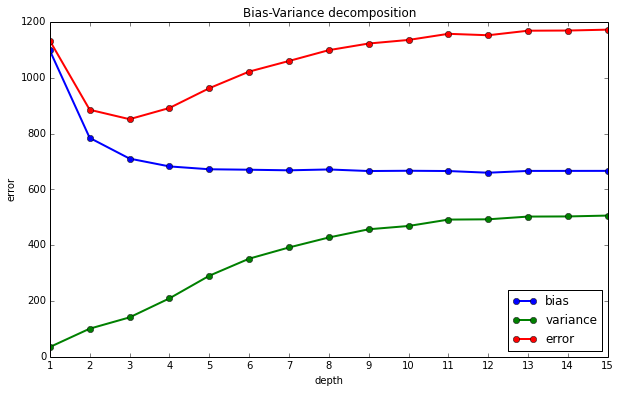

In [39]:
plt.figure(figsize=(10,6))
plt.plot(depthes, biases, label='bias', lw=2, marker='o')
plt.plot(depthes, variances, label='variance', lw=2, marker='o')
plt.plot(depthes, errors, label='error', lw=2, marker='o')
plt.xlim(1, 15)
plt.xticks(depthes)
plt.xlabel('depth')
plt.ylabel('error')
plt.title('Bias-Variance decomposition')
plt.legend(loc='best')
plt.show()

На полученном графике мы наблюдаем, что при увеличении глубины дерева решений, то есть при расширении модели смещение монотонно убывает, а разброс монотонно возрастает. На самом деле в идеале смещение является убывающей функцией от сложности модели, а разброс - возрастающей. Расширение семейства алгоритмов приводит к модели более близкой к идеальной модели, в связи с этим отличие предсказаний нашей модели от предсказаний идеальной модели (т.е. смещение) уменьшается. При этом мы строим более сложные деревья решений, в связи с чем результаты все больше отличаются друг от друга и,значит, растет разброс.

## (6 баллов) Сравнение качества композиций

![](http://i.imgur.com/XztXz7n.png?)

## Random Forest

Обучите Random Forest. Постройте и сравните графики зависимости качества прогноза от количества базовых алгоритмов:
  - на обучающей выборке,
  - на тестовой выборке,
  - используя ошибку Out-of-Bag.

In [79]:
def evaluate(train, test, clf):
    clf = clf.fit(train[train.columns[:-1]], train[train.columns[-1]])
    predict = clf.predict(test[test.columns[:-1]])
    test_score = mean_squared_error(test[test.columns[-1]], predict)
    predict = clf.predict(train[train.columns[:-1]])
    train_score = mean_squared_error(train[train.columns[-1]], predict)
    oob_score = mean_squared_error(train[train.columns[-1]], clf.oob_prediction_)
    print 'MSE train: ', train_score
    print 'MSE test: ', test_score
    print 'OOB score: ', oob_score
    return train_score, test_score, oob_score

res = evaluate(train_set, test_set, RandomForestRegressor(n_estimators=10, oob_score = True))

MSE train:  127.433809664
MSE test:  775.336332091
OOB score:  877.183038324


In [71]:
train_scores = []
test_scores = []
oob_scores = []
size = range(5, 250, 10)

for n in size:
    print 'Estimators: ', n
    train_score, test_score, oob_score = evaluate(train_set, test_set,
                                                 RandomForestRegressor(n_estimators=n, oob_score = True))
    train_scores.append(train_score)
    test_scores.append(test_score)
    oob_scores.append(oob_score)

Estimators:  5
MSE train:  162.218174373
MSE test:  716.465284374
OOB score:  923.228999099
Estimators:  15
MSE train:  107.052566928
MSE test:  699.621087856
OOB score:  752.322208927
Estimators:  25
MSE train:  114.067454033
MSE test:  683.730239968
OOB score:  747.385025838
Estimators:  35
MSE train:  93.7090270403
MSE test:  669.830423495
OOB score:  705.164838233
Estimators:  45
MSE train:  97.9693865854
MSE test:  690.724537301
OOB score:  701.808434952
Estimators:  55
MSE train:  102.112887152
MSE test:  668.512632541
OOB score:  719.398510001
Estimators:  65
MSE train:  94.9835616646
MSE test:  680.551044748
OOB score:  714.50742211
Estimators:  75
MSE train:  91.207064282
MSE test:  660.210505998
OOB score:  664.071184722
Estimators:  85
MSE train:  96.6888687864
MSE test:  633.693077589
OOB score:  666.764850683
Estimators:  95
MSE train:  89.8292015111
MSE test:  661.970018464
OOB score:  680.066999603
Estimators:  105
MSE train:  93.6109494821
MSE test:  651.198740322
OOB s

In [74]:
json.dump(train_scores, open('train_scores.txt', 'w'))
json.dump(test_scores, open('test_scores.txt', 'w'))
json.dump(oob_scores, open('oob_scores.txt', 'w'))

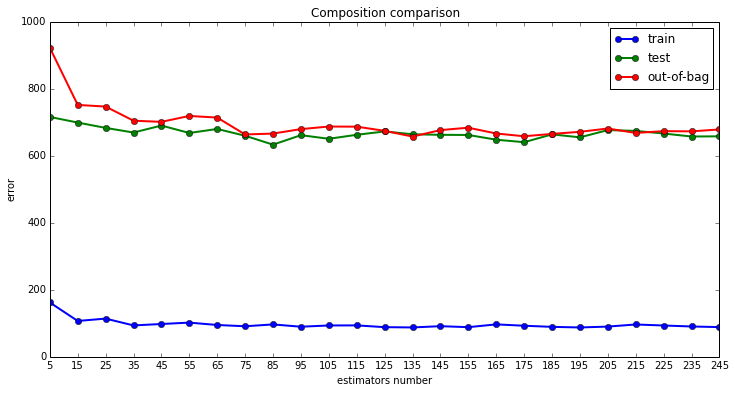

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(size, train_scores, label='train', lw=2, marker='o')
plt.plot(size, test_scores, label='test', lw=2, marker='o')
plt.plot(size, oob_scores, label='out-of-bag', lw=2, marker='o')
plt.xlim(5, 245)
plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('Composition comparison')
plt.legend(loc='best')
plt.show()

Видим, что качество на обучении стабилизировалость. Также можно заметить, что ошибка out-of-bag хорошо моделирует ошибку на тестовой выборке.

## Bagging и RSM 

Обучите Random Forest и композицию деревьев, построенную с помощью техник Bagging и RSM до тех пор, пока качество на обучении не стабилизируется, подобрав оптимальные параметры сабсемлинга по объектам и признаками для каждого метода. Постройте и сравните графики зависимости качества прогнозов этих двух композиций от количества базовых алгоритмов.

In [60]:
def get_scores(clf_type, train, test, size, params):
    train_scores = []
    test_scores = []

    for n in size:
        params['n_estimators']=n
        clf = clf_type(**params)
        clf = clf.fit(train[train.columns[:-1]], train[train.columns[-1]])
        predict = clf.predict(test[test.columns[:-1]])
        test_score = mean_squared_error(test[test.columns[-1]], predict)
        predict = clf.predict(train[train.columns[:-1]])
        train_score = mean_squared_error(train[train.columns[-1]], predict)
        print 'Estimators: ', n
        print 'MSE train: ', train_score
        print 'MSE test: ', test_score
        train_scores.append(train_score)
        test_scores.append(test_score)
    return train_scores, test_scores

In [130]:
train_scores, test_scores = get_scores(BaggingRegressor, train_set, test_set, range(5, 250, 25))

Estimators:  5
MSE train:  157.960974578
MSE test:  725.209621571
OOB score:  987.554514993
Estimators:  30
MSE train:  111.071561533
MSE test:  643.124792764
OOB score:  728.895390347
Estimators:  55
MSE train:  93.6401776634
MSE test:  621.368288103
OOB score:  670.576140094
Estimators:  80
MSE train:  90.6485479161
MSE test:  629.348399405
OOB score:  686.069736628
Estimators:  105
MSE train:  87.2525232895
MSE test:  624.244259498
OOB score:  667.083680466
Estimators:  130
MSE train:  88.0877616363
MSE test:  621.083590203
OOB score:  649.666467265
Estimators:  155
MSE train:  85.1984799565
MSE test:  627.004148279
OOB score:  658.267459711
Estimators:  180
MSE train:  86.9360839563
MSE test:  625.127923497
OOB score:  650.064589689
Estimators:  205
MSE train:  91.3034350243
MSE test:  620.593637591
OOB score:  659.118091974
Estimators:  230
MSE train:  91.8233442325
MSE test:  627.620344156
OOB score:  650.37967129


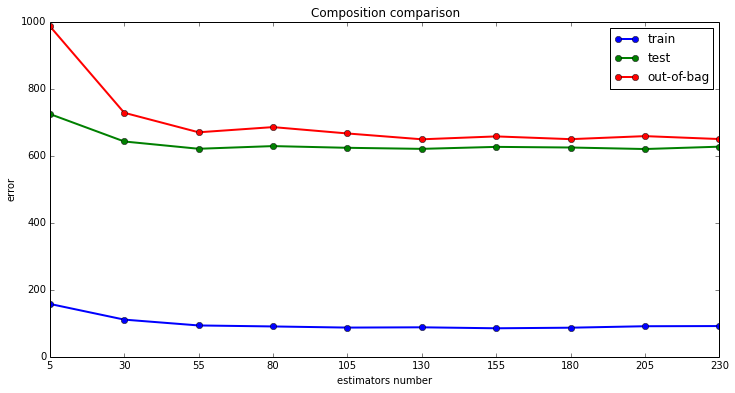

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(size, train_scores, label='train', lw=2, marker='o')
plt.plot(size, test_scores, label='test', lw=2, marker='o')
plt.plot(size, oob_scores, label='out-of-bag', lw=2, marker='o')
plt.xlim(5, 230)
plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('Composition comparison')
plt.legend(loc='best')
plt.show()

Посмотрели, как работает неоптимизированный bagging. Далее будем искать оптимальные параметры для композиции из 35 алгоритмов. Так будет гораздо быстрее.

In [168]:
parameters = {'max_samples': np.linspace(0.1, 1.0, 5),
              'max_features': np.linspace(0.1, 1.0, 5)     
}
bag_clf = BaggingRegressor(n_estimators=35)
bag_clf = GridSearchCV(bag_clf, parameters, verbose=50, scoring='mean_squared_error')
bag_clf.fit(train_set[train_set.columns[:-1]], train_set[train_set.columns[-1]])

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] max_features=0.1, max_samples=0.1 ...............................
[CV] .. max_features=0.1, max_samples=0.1, score=-1095.532940 -   0.3s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.3s
[CV] max_features=0.1, max_samples=0.1 ...............................
[CV] .. max_features=0.1, max_samples=0.1, score=-1148.767988 -   0.2s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.5s
[CV] max_features=0.1, max_samples=0.1 ...............................
[CV] ... max_features=0.1, max_samples=0.1, score=-600.130826 -   0.3s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.8s
[CV] max_features=0.1, max_samples=0.325 .............................
[CV]  max_features=0.1, max_samples=0.325, score=-1065.512631 -   0.4s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    1.2s
[CV] max_features=0.1, max_samples=0.325 .............................
[CV] . max_features=0.1, max_samples=0.325, score=-9

GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=35, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ]), 'max_samples': array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=50)

In [169]:
print 'Best params:', bag_clf.best_params_
print 'Best score:', bag_clf.best_score_

Best params: {'max_features': 0.77500000000000002, 'max_samples': 0.55000000000000004}
Best score: -650.972734963


Оптимальные параметры: max_features: 0.775, max_samples: 0.55

In [183]:
params={'max_features': 0.77500000000000002, 'max_samples': 0.55000000000000004}
bag_train_scores, bag_test_scores = get_scores(BaggingRegressor, train_set, test_set, range(5, 100, 10), params)

Estimators:  5
MSE train:  297.075335831
MSE test:  721.176990905
Estimators:  15
MSE train:  239.29790164
MSE test:  655.025134254
Estimators:  25
MSE train:  235.932674728
MSE test:  638.675518342
Estimators:  35
MSE train:  222.920422111
MSE test:  633.681395799
Estimators:  45
MSE train:  233.130558509
MSE test:  623.925270585
Estimators:  55
MSE train:  212.965070366
MSE test:  640.517307042
Estimators:  65
MSE train:  220.809818764
MSE test:  651.834768243
Estimators:  75
MSE train:  221.144321731
MSE test:  632.166737828
Estimators:  85
MSE train:  216.309993114
MSE test:  640.366376866
Estimators:  95
MSE train:  207.649038419
MSE test:  632.987316036


In [159]:
parameters = {'min_samples_split': [2, 3, 5, 10],
              'max_features': np.linspace(0.1, 1.0, 5),
              'min_samples_leaf': [2, 3, 5, 10]
}
clf = RandomForestRegressor(n_estimators=35, n_jobs=8)
clf = GridSearchCV(clf, parameters, verbose=35, scoring='mean_squared_error')
clf.fit(train_set[train_set.columns[:-1]], train_set[train_set.columns[-1]])

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=2, score=-854.782755 -   0.7s
[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=2, score=-847.545987 -   0.7s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    1.4s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=2, score=-474.701492 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=2, score=-751.790661 -   0.7s

[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    2.8s



[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=2, score=-859.946399 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=2, score=-464.196267 -   0.7s

[Parallel(n_jobs=1)]: Done   5 tasks       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   6 tasks       | elapsed:    4.2s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=2, score=-749.475246 -   0.7s
[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=2, score=-837.154603 -   0.7s

[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done   8 tasks       | elapsed:    5.6s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=2 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=2, score=-485.085794 -   0.7s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=2 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=2, score=-783.177278 -   0.7s

[Parallel(n_jobs=1)]: Done   9 tasks       | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done  10 tasks       | elapsed:    7.0s



[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=2 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=2, score=-896.013773 -   0.7s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=2 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=2, score=-476.326283 -   0.7s

[Parallel(n_jobs=1)]: Done  11 tasks       | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    8.4s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=3, score=-807.462934 -   0.7s
[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=3, score=-851.899294 -   0.7s

[Parallel(n_jobs=1)]: Done  13 tasks       | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done  14 tasks       | elapsed:    9.8s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=3, score=-487.221304 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=3, score=-815.394137 -   0.7s

[Parallel(n_jobs=1)]: Done  15 tasks       | elapsed:   10.6s
[Parallel(n_jobs=1)]: Done  16 tasks       | elapsed:   11.3s



[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=3, score=-840.216197 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=3, score=-485.313021 -   0.8s

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done  18 tasks       | elapsed:   12.8s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=3, score=-777.931414 -   0.8s
[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=3, score=-842.138446 -   0.8s

[Parallel(n_jobs=1)]: Done  19 tasks       | elapsed:   13.6s
[Parallel(n_jobs=1)]: Done  20 tasks       | elapsed:   14.5s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=3 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=3, score=-478.107514 -   0.8s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=3 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=3, score=-764.817273 -   0.7s

[Parallel(n_jobs=1)]: Done  21 tasks       | elapsed:   15.3s
[Parallel(n_jobs=1)]: Done  22 tasks       | elapsed:   16.0s



[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=3 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=3, score=-888.574579 -   0.9s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=3 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=3, score=-479.828873 -   0.7s

[Parallel(n_jobs=1)]: Done  23 tasks       | elapsed:   16.9s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:   17.6s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=5, score=-823.695628 -   0.8s
[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=5, score=-830.464304 -   0.8s

[Parallel(n_jobs=1)]: Done  25 tasks       | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done  26 tasks       | elapsed:   19.2s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=5, score=-494.963586 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=5, score=-787.872746 -   0.7s

[Parallel(n_jobs=1)]: Done  27 tasks       | elapsed:   19.9s
[Parallel(n_jobs=1)]: Done  28 tasks       | elapsed:   20.7s



[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=5, score=-893.839528 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=5, score=-477.426466 -   0.7s

[Parallel(n_jobs=1)]: Done  29 tasks       | elapsed:   21.4s
[Parallel(n_jobs=1)]: Done  30 tasks       | elapsed:   22.1s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=5, score=-780.738385 -   0.7s
[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=5, score=-878.570996 -   0.8s

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:   22.9s
[Parallel(n_jobs=1)]: Done  32 tasks       | elapsed:   23.7s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=5 .......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=5, score=-484.568902 -   0.7s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=5 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=5, score=-808.944892 -   0.7s

[Parallel(n_jobs=1)]: Done  33 tasks       | elapsed:   24.4s
[Parallel(n_jobs=1)]: Done  34 tasks       | elapsed:   25.1s



[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=5 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=5, score=-841.598045 -   0.7s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=5 ......
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=5, score=-480.817713 -   0.7s

[Parallel(n_jobs=1)]: Done  35 tasks       | elapsed:   25.9s
[Parallel(n_jobs=1)]: Done  36 tasks       | elapsed:   26.6s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=10, score=-887.188659 -   0.6s
[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=10, score=-937.384784 -   0.8s

[Parallel(n_jobs=1)]: Done  37 tasks       | elapsed:   27.2s
[Parallel(n_jobs=1)]: Done  38 tasks       | elapsed:   28.0s



[CV] max_features=0.1, min_samples_split=2, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=2, min_samples_leaf=10, score=-517.305842 -   0.6s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=10, score=-876.197309 -   0.7s

[Parallel(n_jobs=1)]: Done  39 tasks       | elapsed:   28.5s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:   29.3s



[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=10, score=-909.774699 -   0.7s
[CV] max_features=0.1, min_samples_split=3, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=3, min_samples_leaf=10, score=-500.162669 -   0.7s

[Parallel(n_jobs=1)]: Done  41 tasks       | elapsed:   30.0s
[Parallel(n_jobs=1)]: Done  42 tasks       | elapsed:   30.7s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=10, score=-868.736835 -   0.6s
[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=10, score=-952.509181 -   0.7s

[Parallel(n_jobs=1)]: Done  43 tasks       | elapsed:   31.3s
[Parallel(n_jobs=1)]: Done  44 tasks       | elapsed:   32.0s



[CV] max_features=0.1, min_samples_split=5, min_samples_leaf=10 ......
[CV]  max_features=0.1, min_samples_split=5, min_samples_leaf=10, score=-499.375670 -   0.7s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=10 .....
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=10, score=-892.390956 -   0.7s

[Parallel(n_jobs=1)]: Done  45 tasks       | elapsed:   32.8s
[Parallel(n_jobs=1)]: Done  46 tasks       | elapsed:   33.6s



[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=10 .....
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=10, score=-928.545001 -   0.7s
[CV] max_features=0.1, min_samples_split=10, min_samples_leaf=10 .....
[CV]  max_features=0.1, min_samples_split=10, min_samples_leaf=10, score=-488.330520 -   0.7s

[Parallel(n_jobs=1)]: Done  47 tasks       | elapsed:   34.3s
[Parallel(n_jobs=1)]: Done  48 tasks       | elapsed:   35.0s



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=2, score=-672.221708 -   1.8s
[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=2, score=-788.436631 -   1.7s

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   36.8s
[Parallel(n_jobs=1)]: Done  50 tasks       | elapsed:   38.5s



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=2, score=-462.211825 -   1.7s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=2, score=-691.774493 -   1.7s

[Parallel(n_jobs=1)]: Done  51 tasks       | elapsed:   40.3s
[Parallel(n_jobs=1)]: Done  52 tasks       | elapsed:   42.0s



[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=2, score=-782.457446 -   1.9s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=2, score=-449.285802 -   1.7s

[Parallel(n_jobs=1)]: Done  53 tasks       | elapsed:   44.0s
[Parallel(n_jobs=1)]: Done  54 tasks       | elapsed:   45.7s



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=2, score=-718.548556 -   1.8s
[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=2, score=-810.102113 -   1.9s

[Parallel(n_jobs=1)]: Done  55 tasks       | elapsed:   47.5s
[Parallel(n_jobs=1)]: Done  56 tasks       | elapsed:   49.4s



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=2 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=2, score=-458.289381 -   1.8s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=2 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=2, score=-693.532522 -   1.5s

[Parallel(n_jobs=1)]: Done  57 tasks       | elapsed:   51.2s
[Parallel(n_jobs=1)]: Done  58 tasks       | elapsed:   52.8s



[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=2 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=2, score=-778.058895 -   1.4s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=2 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=2, score=-459.920119 -   1.5s

[Parallel(n_jobs=1)]: Done  59 tasks       | elapsed:   54.2s
[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:   55.7s



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=3, score=-650.584420 -   1.5s
[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=3, score=-757.591802 -   1.5s

[Parallel(n_jobs=1)]: Done  61 tasks       | elapsed:   57.3s
[Parallel(n_jobs=1)]: Done  62 tasks       | elapsed:   58.8s



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=3, score=-461.113865 -   1.5s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=3, score=-751.259296 -   1.6s

[Parallel(n_jobs=1)]: Done  63 tasks       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  64 tasks       | elapsed:  1.0min



[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=3, score=-795.757478 -   1.4s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=3, score=-473.243497 -   1.4s

[Parallel(n_jobs=1)]: Done  65 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  66 tasks       | elapsed:  1.1min



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=3, score=-756.802297 -   1.4s
[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=3, score=-770.018925 -   1.4s

[Parallel(n_jobs=1)]: Done  67 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  68 tasks       | elapsed:  1.1min



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=3 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=3, score=-466.623943 -   1.5s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=3 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=3, score=-711.956579 -   1.5s

[Parallel(n_jobs=1)]: Done  69 tasks       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  70 tasks       | elapsed:  1.2min



[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=3 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=3, score=-786.729869 -   1.4s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=3 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=3, score=-462.016333 -   1.4s

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  72 tasks       | elapsed:  1.2min



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=5, score=-735.583222 -   1.7s
[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=5, score=-739.186820 -   1.8s

[Parallel(n_jobs=1)]: Done  73 tasks       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  74 tasks       | elapsed:  1.3min



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=5, score=-444.691009 -   1.6s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=5, score=-715.413140 -   1.6s

[Parallel(n_jobs=1)]: Done  75 tasks       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  76 tasks       | elapsed:  1.3min



[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=5, score=-788.656284 -   1.4s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=5, score=-454.578862 -   1.4s

[Parallel(n_jobs=1)]: Done  77 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  78 tasks       | elapsed:  1.4min



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=5, score=-688.663102 -   1.4s
[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=5, score=-792.426047 -   1.3s

[Parallel(n_jobs=1)]: Done  79 tasks       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  80 tasks       | elapsed:  1.4min



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=5 .....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=5, score=-460.602310 -   1.4s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=5 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=5, score=-708.550034 -   1.6s

[Parallel(n_jobs=1)]: Done  81 tasks       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  82 tasks       | elapsed:  1.5min



[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=5 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=5, score=-767.553299 -   1.6s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=5 ....
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=5, score=-453.364611 -   1.6s

[Parallel(n_jobs=1)]: Done  83 tasks       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:  1.5min



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=10, score=-814.887321 -   1.3s
[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=10, score=-830.011063 -   1.5s

[Parallel(n_jobs=1)]: Done  85 tasks       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  86 tasks       | elapsed:  1.6min



[CV] max_features=0.325, min_samples_split=2, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=2, min_samples_leaf=10, score=-473.464689 -   1.4s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=10, score=-789.581873 -   1.4s

[Parallel(n_jobs=1)]: Done  87 tasks       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  88 tasks       | elapsed:  1.6min



[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=10, score=-849.330227 -   1.4s
[CV] max_features=0.325, min_samples_split=3, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=3, min_samples_leaf=10, score=-487.180612 -   1.6s

[Parallel(n_jobs=1)]: Done  89 tasks       | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  90 tasks       | elapsed:  1.7min



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=10, score=-815.457850 -   1.7s
[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=10, score=-784.950742 -   1.5s

[Parallel(n_jobs=1)]: Done  91 tasks       | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  92 tasks       | elapsed:  1.7min



[CV] max_features=0.325, min_samples_split=5, min_samples_leaf=10 ....
[CV]  max_features=0.325, min_samples_split=5, min_samples_leaf=10, score=-490.974842 -   1.4s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=10 ...
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=10, score=-767.723919 -   1.7s

[Parallel(n_jobs=1)]: Done  93 tasks       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  94 tasks       | elapsed:  1.8min



[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=10 ...
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=10, score=-828.584696 -   1.6s
[CV] max_features=0.325, min_samples_split=10, min_samples_leaf=10 ...
[CV]  max_features=0.325, min_samples_split=10, min_samples_leaf=10, score=-483.000870 -   1.4s

[Parallel(n_jobs=1)]: Done  95 tasks       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  96 tasks       | elapsed:  1.8min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=2, score=-662.527025 -   3.2s
[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=2, score=-788.974967 -   3.1s

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  98 tasks       | elapsed:  1.9min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=2, score=-496.828991 -   3.1s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=2, score=-700.396507 -   3.1s

[Parallel(n_jobs=1)]: Done  99 tasks       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 100 tasks       | elapsed:  2.0min



[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=2, score=-744.006467 -   3.0s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=2, score=-455.181594 -   3.0s

[Parallel(n_jobs=1)]: Done 101 tasks       | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done 102 tasks       | elapsed:  2.1min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=2, score=-653.778540 -   3.3s
[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=2, score=-776.803667 -   2.4s

[Parallel(n_jobs=1)]: Done 103 tasks       | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 104 tasks       | elapsed:  2.2min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=2 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=2, score=-483.829721 -   2.9s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=2 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=2, score=-680.797110 -   2.9s

[Parallel(n_jobs=1)]: Done 105 tasks       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 106 tasks       | elapsed:  2.3min



[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=2 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=2, score=-762.343878 -   2.8s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=2 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=2, score=-483.498198 -   2.7s

[Parallel(n_jobs=1)]: Done 107 tasks       | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 108 tasks       | elapsed:  2.4min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=3, score=-676.813054 -   2.3s
[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=3, score=-767.062884 -   2.7s

[Parallel(n_jobs=1)]: Done 109 tasks       | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done 110 tasks       | elapsed:  2.5min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=3, score=-489.086474 -   2.8s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=3, score=-701.768573 -   2.6s

[Parallel(n_jobs=1)]: Done 111 tasks       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:  2.6min



[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=3, score=-753.069592 -   2.2s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=3, score=-487.847270 -   2.2s

[Parallel(n_jobs=1)]: Done 113 tasks       | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 114 tasks       | elapsed:  2.7min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=3, score=-698.886709 -   2.4s
[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=3, score=-760.090329 -   2.4s

[Parallel(n_jobs=1)]: Done 115 tasks       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 116 tasks       | elapsed:  2.8min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=3 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=3, score=-473.147274 -   2.4s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=3 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=3, score=-713.399304 -   2.2s

[Parallel(n_jobs=1)]: Done 117 tasks       | elapsed:  2.8min
[Parallel(n_jobs=1)]: Done 118 tasks       | elapsed:  2.8min



[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=3 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=3, score=-787.193371 -   2.2s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=3 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=3, score=-471.414050 -   2.2s

[Parallel(n_jobs=1)]: Done 119 tasks       | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 120 tasks       | elapsed:  2.9min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=5, score=-713.429262 -   2.4s
[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=5, score=-755.191721 -   2.5s

[Parallel(n_jobs=1)]: Done 121 tasks       | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 122 tasks       | elapsed:  3.0min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=5, score=-471.529064 -   2.5s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=5, score=-724.915249 -   2.6s

[Parallel(n_jobs=1)]: Done 123 tasks       | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 124 tasks       | elapsed:  3.1min



[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=5, score=-748.839809 -   2.7s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=5, score=-481.237223 -   2.5s

[Parallel(n_jobs=1)]: Done 125 tasks       | elapsed:  3.1min
[Parallel(n_jobs=1)]: Done 126 tasks       | elapsed:  3.2min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=5, score=-688.479936 -   2.3s
[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=5, score=-765.125439 -   2.2s

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 128 tasks       | elapsed:  3.2min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=5 ......
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=5, score=-481.710488 -   2.3s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=5 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=5, score=-705.126787 -   2.1s

[Parallel(n_jobs=1)]: Done 129 tasks       | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done 130 tasks       | elapsed:  3.3min



[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=5 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=5, score=-789.662878 -   2.3s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=5 .....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=5, score=-455.450630 -   2.1s

[Parallel(n_jobs=1)]: Done 131 tasks       | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done 132 tasks       | elapsed:  3.4min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=10, score=-778.210274 -   2.0s
[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=10, score=-783.109516 -   1.8s

[Parallel(n_jobs=1)]: Done 133 tasks       | elapsed:  3.4min
[Parallel(n_jobs=1)]: Done 134 tasks       | elapsed:  3.5min



[CV] max_features=0.55, min_samples_split=2, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=2, min_samples_leaf=10, score=-471.136429 -   1.9s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=10, score=-745.863091 -   1.9s

[Parallel(n_jobs=1)]: Done 135 tasks       | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done 136 tasks       | elapsed:  3.5min



[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=10, score=-799.269869 -   2.2s
[CV] max_features=0.55, min_samples_split=3, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=3, min_samples_leaf=10, score=-479.137180 -   2.5s

[Parallel(n_jobs=1)]: Done 137 tasks       | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done 138 tasks       | elapsed:  3.6min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=10, score=-788.011442 -   2.3s
[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=10, score=-809.665150 -   2.2s

[Parallel(n_jobs=1)]: Done 139 tasks       | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done 140 tasks       | elapsed:  3.7min



[CV] max_features=0.55, min_samples_split=5, min_samples_leaf=10 .....
[CV]  max_features=0.55, min_samples_split=5, min_samples_leaf=10, score=-466.367868 -   2.5s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=10 ....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=10, score=-800.391367 -   2.7s

[Parallel(n_jobs=1)]: Done 141 tasks       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done 142 tasks       | elapsed:  3.8min



[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=10 ....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=10, score=-783.379354 -   2.4s
[CV] max_features=0.55, min_samples_split=10, min_samples_leaf=10 ....
[CV]  max_features=0.55, min_samples_split=10, min_samples_leaf=10, score=-481.837685 -   2.3s

[Parallel(n_jobs=1)]: Done 143 tasks       | elapsed:  3.8min
[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed:  3.8min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=2, score=-735.951856 -   3.6s
[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=2, score=-778.833459 -   3.4s

[Parallel(n_jobs=1)]: Done 145 tasks       | elapsed:  3.9min
[Parallel(n_jobs=1)]: Done 146 tasks       | elapsed:  4.0min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=2, score=-453.969565 -   4.2s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=2, score=-737.455647 -   3.7s

[Parallel(n_jobs=1)]: Done 147 tasks       | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done 148 tasks       | elapsed:  4.1min



[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=2, score=-777.930358 -   3.5s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=2, score=-470.289238 -   4.1s

[Parallel(n_jobs=1)]: Done 149 tasks       | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done 150 tasks       | elapsed:  4.2min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=2, score=-706.738552 -   3.9s
[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=2, score=-771.115126 -   3.9s

[Parallel(n_jobs=1)]: Done 151 tasks       | elapsed:  4.3min
[Parallel(n_jobs=1)]: Done 152 tasks       | elapsed:  4.3min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=2 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=2, score=-479.278660 -   3.8s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=2 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=2, score=-710.561892 -   4.2s

[Parallel(n_jobs=1)]: Done 153 tasks       | elapsed:  4.4min
[Parallel(n_jobs=1)]: Done 154 tasks       | elapsed:  4.5min



[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=2 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=2, score=-766.541319 -   4.8s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=2 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=2, score=-497.885822 -   4.5s

[Parallel(n_jobs=1)]: Done 155 tasks       | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done 156 tasks       | elapsed:  4.6min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=3, score=-750.439216 -   4.1s
[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=3, score=-762.355798 -   3.5s

[Parallel(n_jobs=1)]: Done 157 tasks       | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done 158 tasks       | elapsed:  4.8min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=3, score=-459.925561 -   4.5s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=3, score=-698.344566 -   4.3s

[Parallel(n_jobs=1)]: Done 159 tasks       | elapsed:  4.8min
[Parallel(n_jobs=1)]: Done 160 tasks       | elapsed:  4.9min



[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=3, score=-787.877027 -   3.4s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=3, score=-474.767113 -   3.4s

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:  5.0min
[Parallel(n_jobs=1)]: Done 162 tasks       | elapsed:  5.0min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=3, score=-774.726218 -   4.2s
[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=3, score=-741.534120 -   3.6s

[Parallel(n_jobs=1)]: Done 163 tasks       | elapsed:  5.1min
[Parallel(n_jobs=1)]: Done 164 tasks       | elapsed:  5.2min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=3 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=3, score=-508.333001 -   4.1s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=3 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=3, score=-717.661179 -   4.1s

[Parallel(n_jobs=1)]: Done 165 tasks       | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done 166 tasks       | elapsed:  5.3min



[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=3 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=3, score=-764.700220 -   4.0s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=3 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=3, score=-468.233149 -   3.9s

[Parallel(n_jobs=1)]: Done 167 tasks       | elapsed:  5.4min
[Parallel(n_jobs=1)]: Done 168 tasks       | elapsed:  5.4min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=5, score=-721.426011 -   3.9s
[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=5, score=-744.141567 -   3.9s

[Parallel(n_jobs=1)]: Done 169 tasks       | elapsed:  5.5min
[Parallel(n_jobs=1)]: Done 170 tasks       | elapsed:  5.6min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=5, score=-482.511322 -   3.3s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=5, score=-758.299033 -   3.7s

[Parallel(n_jobs=1)]: Done 171 tasks       | elapsed:  5.6min
[Parallel(n_jobs=1)]: Done 172 tasks       | elapsed:  5.7min



[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=5, score=-741.469328 -   4.4s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=5, score=-431.269925 -   3.6s

[Parallel(n_jobs=1)]: Done 173 tasks       | elapsed:  5.7min
[Parallel(n_jobs=1)]: Done 174 tasks       | elapsed:  5.8min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=5, score=-739.085674 -   3.3s
[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=5, score=-730.070196 -   3.1s

[Parallel(n_jobs=1)]: Done 175 tasks       | elapsed:  5.9min
[Parallel(n_jobs=1)]: Done 176 tasks       | elapsed:  5.9min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=5 .....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=5, score=-488.838310 -   3.3s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=5 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=5, score=-744.187501 -   3.7s

[Parallel(n_jobs=1)]: Done 177 tasks       | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done 178 tasks       | elapsed:  6.0min



[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=5 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=5, score=-745.429587 -   3.8s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=5 ....
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=5, score=-485.128788 -   3.4s

[Parallel(n_jobs=1)]: Done 179 tasks       | elapsed:  6.1min
[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed:  6.1min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=10, score=-806.659077 -   3.0s
[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=10, score=-767.109614 -   2.9s

[Parallel(n_jobs=1)]: Done 181 tasks       | elapsed:  6.2min
[Parallel(n_jobs=1)]: Done 182 tasks       | elapsed:  6.2min



[CV] max_features=0.775, min_samples_split=2, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=2, min_samples_leaf=10, score=-461.004311 -   2.7s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=10, score=-799.492833 -   2.9s

[Parallel(n_jobs=1)]: Done 183 tasks       | elapsed:  6.3min
[Parallel(n_jobs=1)]: Done 184 tasks       | elapsed:  6.3min



[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=10, score=-788.330031 -   2.9s
[CV] max_features=0.775, min_samples_split=3, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=3, min_samples_leaf=10, score=-458.584279 -   3.0s

[Parallel(n_jobs=1)]: Done 185 tasks       | elapsed:  6.4min
[Parallel(n_jobs=1)]: Done 186 tasks       | elapsed:  6.4min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=10, score=-786.334168 -   2.6s
[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=10, score=-774.666646 -   2.7s

[Parallel(n_jobs=1)]: Done 187 tasks       | elapsed:  6.5min
[Parallel(n_jobs=1)]: Done 188 tasks       | elapsed:  6.5min



[CV] max_features=0.775, min_samples_split=5, min_samples_leaf=10 ....
[CV]  max_features=0.775, min_samples_split=5, min_samples_leaf=10, score=-459.642851 -   3.1s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=10 ...
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=10, score=-761.518685 -   3.0s

[Parallel(n_jobs=1)]: Done 189 tasks       | elapsed:  6.6min
[Parallel(n_jobs=1)]: Done 190 tasks       | elapsed:  6.6min



[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=10 ...
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=10, score=-760.643916 -   3.3s
[CV] max_features=0.775, min_samples_split=10, min_samples_leaf=10 ...
[CV]  max_features=0.775, min_samples_split=10, min_samples_leaf=10, score=-480.047276 -   3.5s

[Parallel(n_jobs=1)]: Done 191 tasks       | elapsed:  6.7min
[Parallel(n_jobs=1)]: Done 192 tasks       | elapsed:  6.7min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=2, score=-715.710633 -   6.1s
[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=2, score=-790.115172 -   6.4s

[Parallel(n_jobs=1)]: Done 193 tasks       | elapsed:  6.8min
[Parallel(n_jobs=1)]: Done 194 tasks       | elapsed:  6.9min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=2, score=-473.890871 -   5.6s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=2, score=-732.914957 -   4.7s

[Parallel(n_jobs=1)]: Done 195 tasks       | elapsed:  7.0min
[Parallel(n_jobs=1)]: Done 196 tasks       | elapsed:  7.1min



[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=2, score=-785.457217 -   4.7s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=2, score=-496.198704 -   6.0s

[Parallel(n_jobs=1)]: Done 197 tasks       | elapsed:  7.2min
[Parallel(n_jobs=1)]: Done 198 tasks       | elapsed:  7.3min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=2, score=-679.582864 -   5.6s
[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=2, score=-757.714056 -   5.2s

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  7.4min
[Parallel(n_jobs=1)]: Done 200 tasks       | elapsed:  7.5min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=2 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=2, score=-466.814686 -   5.8s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=2 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=2, score=-679.964969 -   4.5s

[Parallel(n_jobs=1)]: Done 201 tasks       | elapsed:  7.6min
[Parallel(n_jobs=1)]: Done 202 tasks       | elapsed:  7.7min



[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=2 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=2, score=-786.376060 -   5.0s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=2 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=2, score=-475.121705 -   5.5s

[Parallel(n_jobs=1)]: Done 203 tasks       | elapsed:  7.7min
[Parallel(n_jobs=1)]: Done 204 tasks       | elapsed:  7.8min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=3, score=-704.587623 -   5.5s
[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=3, score=-745.669353 -   5.2s

[Parallel(n_jobs=1)]: Done 205 tasks       | elapsed:  7.9min
[Parallel(n_jobs=1)]: Done 206 tasks       | elapsed:  8.0min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=3, score=-485.886329 -   5.4s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=3, score=-669.460766 -   6.3s

[Parallel(n_jobs=1)]: Done 207 tasks       | elapsed:  8.1min
[Parallel(n_jobs=1)]: Done 208 tasks       | elapsed:  8.2min



[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=3, score=-747.303110 -   5.7s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=3, score=-460.161018 -   5.3s

[Parallel(n_jobs=1)]: Done 209 tasks       | elapsed:  8.3min
[Parallel(n_jobs=1)]: Done 210 tasks       | elapsed:  8.4min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=3, score=-735.228618 -   4.9s
[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=3, score=-769.320972 -   5.2s

[Parallel(n_jobs=1)]: Done 211 tasks       | elapsed:  8.5min
[Parallel(n_jobs=1)]: Done 212 tasks       | elapsed:  8.6min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=3 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=3, score=-467.996223 -   5.1s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=3 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=3, score=-723.951397 -   4.8s

[Parallel(n_jobs=1)]: Done 213 tasks       | elapsed:  8.6min
[Parallel(n_jobs=1)]: Done 214 tasks       | elapsed:  8.7min



[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=3 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=3, score=-760.071782 -   4.9s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=3 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=3, score=-473.814396 -   5.1s

[Parallel(n_jobs=1)]: Done 215 tasks       | elapsed:  8.8min
[Parallel(n_jobs=1)]: Done 216 tasks       | elapsed:  8.9min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=5, score=-790.878059 -   4.2s
[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=5, score=-737.269714 -   4.6s

[Parallel(n_jobs=1)]: Done 217 tasks       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 218 tasks       | elapsed:  9.0min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=5, score=-467.698348 -   3.8s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=5, score=-741.495410 -   3.9s

[Parallel(n_jobs=1)]: Done 219 tasks       | elapsed:  9.1min
[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed:  9.2min



[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=5, score=-749.405547 -   4.7s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=5, score=-478.332659 -   4.6s

[Parallel(n_jobs=1)]: Done 221 tasks       | elapsed:  9.2min
[Parallel(n_jobs=1)]: Done 222 tasks       | elapsed:  9.3min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=5, score=-767.347178 -   3.8s
[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=5, score=-762.346218 -   4.2s

[Parallel(n_jobs=1)]: Done 223 tasks       | elapsed:  9.4min
[Parallel(n_jobs=1)]: Done 224 tasks       | elapsed:  9.5min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=5 .......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=5, score=-464.954163 -   3.9s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=5 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=5, score=-723.638163 -   4.5s

[Parallel(n_jobs=1)]: Done 225 tasks       | elapsed:  9.5min
[Parallel(n_jobs=1)]: Done 226 tasks       | elapsed:  9.6min



[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=5 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=5, score=-774.119221 -   4.7s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=5 ......
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=5, score=-453.431975 -   4.2s

[Parallel(n_jobs=1)]: Done 227 tasks       | elapsed:  9.7min
[Parallel(n_jobs=1)]: Done 228 tasks       | elapsed:  9.7min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=10, score=-784.292801 -   3.8s
[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=10, score=-785.142767 -   4.5s

[Parallel(n_jobs=1)]: Done 229 tasks       | elapsed:  9.8min
[Parallel(n_jobs=1)]: Done 230 tasks       | elapsed:  9.9min



[CV] max_features=1.0, min_samples_split=2, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=2, min_samples_leaf=10, score=-482.441083 -   4.2s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=10, score=-836.470767 -   3.6s

[Parallel(n_jobs=1)]: Done 231 tasks       | elapsed:  9.9min
[Parallel(n_jobs=1)]: Done 232 tasks       | elapsed: 10.0min



[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=10, score=-765.015244 -   4.4s
[CV] max_features=1.0, min_samples_split=3, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=3, min_samples_leaf=10, score=-495.321678 -   4.2s

[Parallel(n_jobs=1)]: Done 233 tasks       | elapsed: 10.1min
[Parallel(n_jobs=1)]: Done 234 tasks       | elapsed: 10.2min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=10, score=-757.552929 -   3.9s
[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=10, score=-746.561967 -   4.0s

[Parallel(n_jobs=1)]: Done 235 tasks       | elapsed: 10.2min
[Parallel(n_jobs=1)]: Done 236 tasks       | elapsed: 10.3min



[CV] max_features=1.0, min_samples_split=5, min_samples_leaf=10 ......
[CV]  max_features=1.0, min_samples_split=5, min_samples_leaf=10, score=-472.034278 -   3.7s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=10 .....
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=10, score=-800.488217 -   3.8s

[Parallel(n_jobs=1)]: Done 237 tasks       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 238 tasks       | elapsed: 10.4min



[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=10 .....
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=10, score=-764.669495 -   4.2s
[CV] max_features=1.0, min_samples_split=10, min_samples_leaf=10 .....
[CV]  max_features=1.0, min_samples_split=10, min_samples_leaf=10, score=-486.993223 -   4.3s

[Parallel(n_jobs=1)]: Done 239 tasks       | elapsed: 10.5min
[Parallel(n_jobs=1)]: Done 240 tasks       | elapsed: 10.5min


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 10.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=35, n_jobs=8, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 5, 10], 'max_features': array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ]), 'min_samples_leaf': [2, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=35)

In [161]:
print 'Best params:', clf.best_params_
print 'Best score:', clf.best_score_

Best params: {'max_features': 0.32500000000000001, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best score: -623.096695594


Оптимальные параметры: max_features: 0.32500000000000001, min_samples_split: 2, min_samples_leaf: 3 <br>
MSE: 623.096695594

In [62]:
params={'max_features': 0.32500000000000001, 'min_samples_split': 2, 'min_samples_leaf': 3}
train_scores, test_scores = get_scores(RandomForestRegressor, train_set, test_set, range(5, 100, 10), params)

Estimators:  5
MSE train:  280.071418175
MSE test:  668.338441379
Estimators:  15
MSE train:  244.025336567
MSE test:  653.400009715
Estimators:  25
MSE train:  234.199212334
MSE test:  655.490582058
Estimators:  35
MSE train:  243.564128549
MSE test:  643.947020828
Estimators:  45
MSE train:  234.583928329
MSE test:  647.93000425
Estimators:  55
MSE train:  227.497271163
MSE test:  643.096783914
Estimators:  65
MSE train:  230.429947347
MSE test:  633.350447644
Estimators:  75
MSE train:  225.377068014
MSE test:  640.794051023
Estimators:  85
MSE train:  228.5784008
MSE test:  637.776171019
Estimators:  95
MSE train:  225.288103331
MSE test:  640.040271472


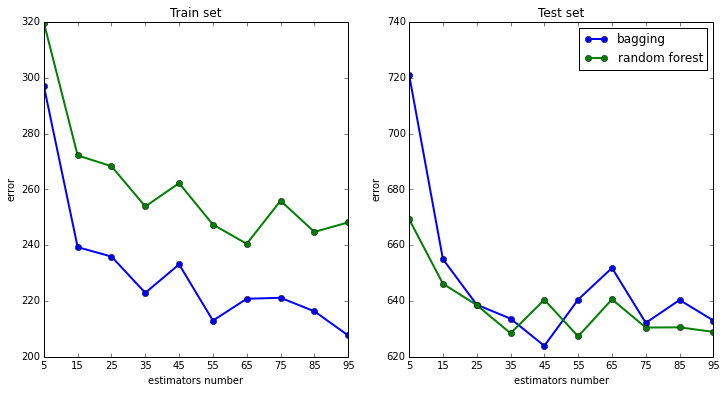

In [185]:
size = range(5, 100, 10)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(size, bag_train_scores, label='bagging', lw=2, marker='o')
plt.plot(size, train_scores, label='random forest', lw=2, marker='o')
plt.xlim(5, 80)
plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('Train set')
plt.subplot(122)
plt.plot(size, bag_test_scores, label='bagging', lw=2, marker='o')
plt.plot(size, test_scores, label='random forest', lw=2, marker='o')
plt.xlim(5, 80)
plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('Test set')
plt.legend(loc='best')
plt.show()

На тренировочной выборке победил Bagging. На тестовой все же лучшим оказался Random forest. Хотя самая лучшая модель - это Bagging из 45 базовых алгоритмов.

## Gradient Boost

Обучите градиентый бустинг над 100 деревьями с одинаковыми параметрами, используя библиотеки scikit-learn и xgboost. Сравните получившиеся композиции, построив графики качества на обучающей и тестовой выборке в зависимости от количества деревьев. В дальнейших экспериментах используйте реализацию бустинга, показавшую лучший результат.

In [91]:
clf = GradientBoostingRegressor(n_estimators=100)
clf.fit(train_set[train_set.columns[:-1]], train_set[train_set.columns[-1]])

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [92]:
sk_train_scores = []
sk_test_scores = []
train_predicts = clf.staged_predict(train_set[train_set.columns[:-1]])
test_predicts = clf.staged_predict(test_set[test_set.columns[:-1]])
for i, predict in enumerate(train_predicts):
    train_score = mean_squared_error(predict, train_set[train_set.columns[-1]])
    sk_train_scores.append(train_score)
for i, predict in enumerate(test_predicts):
    test_score = mean_squared_error(predict, test_set[test_set.columns[-1]])
    sk_test_scores.append(test_score)

In [93]:
train_data = np.array(train_set[train_set.columns[:-1]])
labels = np.array(train_set[train_set.columns[-1]])
test_data = np.array(test_set[test_set.columns[:-1]])
test_labels = np.array(test_set[test_set.columns[-1]])
dtrain = xgb.DMatrix(train_data, label=labels)
dtest = xgb.DMatrix(test_data, label=test_labels)

In [94]:
param = {'bst:max_depth':3, 'bst:eta':0.1, 'silent':1,
        'eval_metric':'rmse', 'nthread':4}
evallist  = [(dtest,'eval'), (dtrain,'train')]

In [95]:
bst = xgb.train(param, dtrain, 100, evallist, early_stopping_rounds=10)

Will train until train error hasn't decreased in 10 rounds.
[0]	eval-rmse:33.024746	train-rmse:29.587259
[1]	eval-rmse:30.059578	train-rmse:24.332916
[2]	eval-rmse:28.311743	train-rmse:20.534853
[3]	eval-rmse:27.382818	train-rmse:17.754658
[4]	eval-rmse:27.031353	train-rmse:15.809454
[5]	eval-rmse:26.652878	train-rmse:14.568861
[6]	eval-rmse:26.452236	train-rmse:13.360563
[7]	eval-rmse:26.288221	train-rmse:12.380862
[8]	eval-rmse:26.170542	train-rmse:11.708527
[9]	eval-rmse:26.148310	train-rmse:11.319448
[10]	eval-rmse:26.181217	train-rmse:11.008653
[11]	eval-rmse:26.139065	train-rmse:10.801548
[12]	eval-rmse:26.161245	train-rmse:10.633608
[13]	eval-rmse:26.183489	train-rmse:10.438463
[14]	eval-rmse:26.192457	train-rmse:10.317122
[15]	eval-rmse:26.196844	train-rmse:10.245735
[16]	eval-rmse:26.161274	train-rmse:9.939538
[17]	eval-rmse:26.148909	train-rmse:9.604264
[18]	eval-rmse:26.126123	train-rmse:9.080054
[19]	eval-rmse:26.134689	train-rmse:8.927215
[20]	eval-rmse:26.142447	train-rms

In [100]:
bst_train_scores = []
bst_test_scores = []
for size in range(1, 101):
    test_predict = bst.predict(dtest, ntree_limit=size)
    test_score = mean_squared_error(test_predict, test_labels)
    train_predict = bst.predict(dtrain, ntree_limit=size)
    train_score = mean_squared_error(train_predict, labels)
    bst_train_scores.append(train_score)
    bst_test_scores.append(test_score)

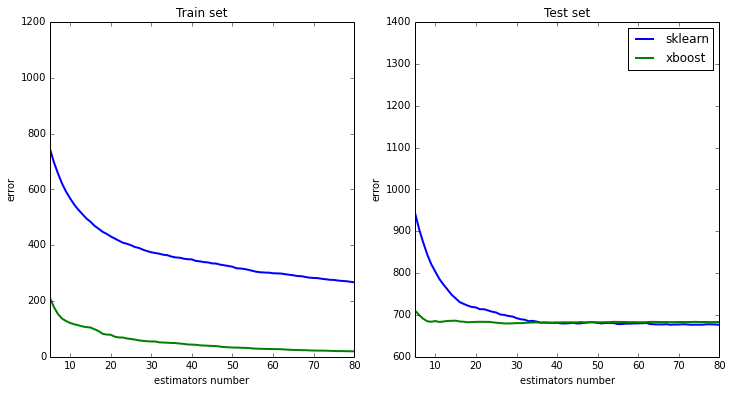

In [104]:
size = range(0, 100)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(size, sk_train_scores, label='sklearn', lw=2)
plt.plot(size, bst_train_scores, label='xboost', lw=2)
plt.xlim(5, 80)
#plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('Train set')
plt.subplot(122)
plt.plot(size, sk_test_scores, label='sklearn', lw=2)
plt.plot(size, bst_test_scores, label='xboost', lw=2)
plt.xlim(5, 80)
#plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('Test set')
plt.legend(loc='best')
plt.show()

Видим, что на xboost намного лучше подстраивается под данные из обучающей выборки. На тестовой выборке, начиная от 40 деревьев алгоритмы дают примерно одинаковое качество. В качестве победителя выберем xboost так как его предсказания в целом лучше для разного количества деревьев.

## Compositions and Gradient Boost

Сравните лучшую композицию из пункта 2 с лучшим бустингом из пункта 3 по следующим параметрам:
  - время обучения в зависимости от количества деревьев,
  - качество предсказания на тестовой выборке в зависимости от количества деревьев.

In [53]:
rf_test_scores = []
rf_times = []
for n in xrange(1, 101, 10):
    clf = RandomForestRegressor(n_estimators=n, max_features=0.325, min_samples_split=2, min_samples_leaf=3)
    start_time = time()
    clf = clf.fit(train_set[train_set.columns[:-1]], train_set[train_set.columns[-1]])
    end_time = time()-start_time
    predict = clf.predict(test_set[test_set.columns[:-1]])
    test_score = mean_squared_error(test_set[test_set.columns[-1]], predict)
    rf_test_scores.append(test_score)
    rf_times.append(end_time)
    print 'Estimators:', n
    print 'Time: {:.2f}'.format(end_time)
    print 'MSE: {:.2f}'.format(test_score)  

Estimators: 1
Time: 0.22
MSE: 1091.02
Estimators: 11
Time: 1.53
MSE: 673.13
Estimators: 21
Time: 3.00
MSE: 652.99
Estimators: 31
Time: 4.42
MSE: 654.93
Estimators: 41
Time: 5.65
MSE: 646.27
Estimators: 51
Time: 7.15
MSE: 638.03
Estimators: 61
Time: 8.80
MSE: 643.53
Estimators: 71
Time: 10.50
MSE: 637.57
Estimators: 81
Time: 11.84
MSE: 640.90
Estimators: 91
Time: 13.73
MSE: 640.72


In [117]:
bst_test_scores = []
bst_times = []
for n in xrange(1, 101, 10):
    start_time = time()
    bst = xgb.train(param, dtrain, n, evallist, verbose_eval=False)
    end_time = time()-start_time
    predict = bst.predict(dtest, ntree_limit=n)
    test_score = mean_squared_error(test_labels, predict)
    bst_test_scores.append(test_score)
    bst_times.append(end_time)
    print 'Estimators:', n
    print 'Time: {:.2f}'.format(end_time)
    print 'MSE: {:.2f}'.format(test_score)  

Estimators: 1
Time: 0.19
MSE: 1090.63
Estimators: 11
Time: 2.29
MSE: 685.46
Estimators: 21
Time: 3.98
MSE: 683.43
Estimators: 31
Time: 5.72
MSE: 680.42
Estimators: 41
Time: 8.41
MSE: 681.91
Estimators: 51
Time: 9.91
MSE: 682.46
Estimators: 61
Time: 11.85
MSE: 682.62
Estimators: 71
Time: 14.06
MSE: 683.15
Estimators: 81
Time: 15.90
MSE: 683.02
Estimators: 91
Time: 17.70
MSE: 683.72


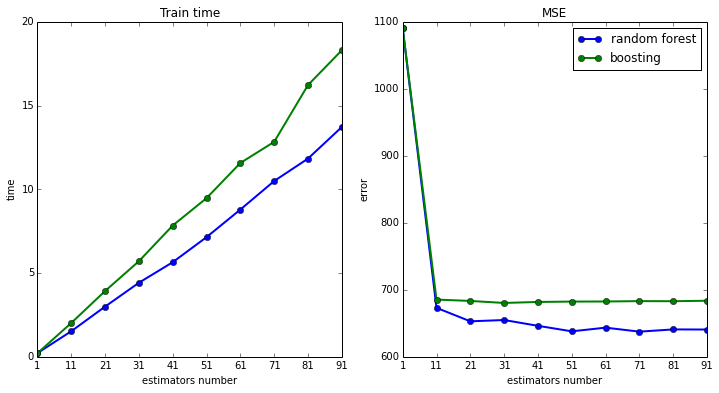

In [57]:
size = range(1, 101, 10)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(size, rf_times, label='random forest', lw=2, marker='o')
plt.plot(size, bst_times, label='boosting', lw=2, marker='o')
plt.xlim(5, 80)
plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('time')
plt.title('Train time')
plt.subplot(122)
plt.plot(size, rf_test_scores, label='random forest', lw=2, marker='o')
plt.plot(size, bst_test_scores, label='boosting', lw=2, marker='o')
plt.xlim(5, 80)
plt.xticks(size)
plt.xlabel('estimators number')
plt.ylabel('error')
plt.title('MSE')
plt.legend(loc='best')
plt.show()

Вывод: бустинг обучается дольше, но дает лучшее качество на тестовой выборке, в сравнении с random forest. Время обучения обеих моделей линейно зависит от числа базовых алгоритмов.

##  Gradient boosting с начальным приближением

Используйте лучшую композицию из пункта 2 в качестве начального приближения для градиентного бустинга над деревьями, т.е. обучайте бустинг на ошибки, которые дает композиция. Аналогичную операцию проделайте для начального приближения линейной регрессией. Дали ли подобные подходы прирост качества по сравнению с обычным градиентным бустингом и почему?

In [148]:
train_data = np.array(train_set[train_set.columns[:-1]])
labels = np.array(train_set[train_set.columns[-1]])
test_data = np.array(test_set[test_set.columns[:-1]])
test_labels = np.array(test_set[test_set.columns[-1]])
dtrain = xgb.DMatrix(train_data, label=labels)
dtest = xgb.DMatrix(test_data, label=test_labels)
param = {'bst:max_depth':3, 'bst:eta':0.1, 'silent':1,
        'eval_metric':'rmse', 'nthread':4}
evallist  = [(dtest,'eval'), (dtrain,'train')]

In [150]:
lin_reg_clf = LinearRegression()
lin_reg_clf=lin_reg_clf.fit(train_set[train_set.columns[:-1]], train_set[train_set.columns[-1]])
lr_predicts = lin_reg_clf.predict(train_set[train_set.columns[:-1]])
lr_test_predict = lin_reg_clf.predict(test_set[test_set.columns[:-1]])
print 'Linear regression (train) mse: {:.2f}'.format(mean_squared_error(lr_predicts, labels))
print 'Linear regression (test) mse: {:.2f}'.format(mean_squared_error(lr_test_predict, test_labels))
dtrain_lr = xgb.DMatrix(train_data, label=labels)
dtrain_lr.set_base_margin(lr_predicts)
dtest_lr = xgb.DMatrix(test_data, label=test_labels)
dtest_lr.set_base_margin(lr_test_predict)

Linear regression (train) mse: 715.29
Linear regression (test) mse: 980.35


In [151]:
bag_reg_clf = BaggingRegressor(n_estimators=250, max_features=0.775, max_samples=0.55, n_jobs=8)
bag_reg_clf.fit(train_set[train_set.columns[:-1]], train_set[train_set.columns[-1]])
bag_predict = bag_reg_clf.predict(train_set[train_set.columns[:-1]])
bag_test_predict = bag_reg_clf.predict(test_set[test_set.columns[:-1]])
dtrain_bag = xgb.DMatrix(train_data, label=labels)
dtrain_bag.set_base_margin(bag_predict)
dtest_bag = xgb.DMatrix(test_data, label=test_labels)
dtest_bag.set_base_margin(bag_test_predict)
print 'Bagging mse (train): {:.2f}'.format(mean_squared_error(bag_predict, labels))
print 'Bagging mse (test): {:.2f}'.format(mean_squared_error(bag_test_predict, test_labels))

Bagging mse (train): 166.42
Bagging mse (test): 644.23


In [152]:
bst_bag = xgb.train(param, dtrain_bag, 100, evallist, verbose_eval=False, early_stopping_rounds=10)
bst_lr = xgb.train(param, dtrain_lr, 100, evallist, verbose_eval=False, early_stopping_rounds=10)
bst = xgb.train(param, dtrain, 100, evallist, verbose_eval=False, early_stopping_rounds=10)

In [153]:
bag_test_scores = []
lr_test_scores = []
bst_test_scores = []

for n in xrange(1, 101):
    bst_bag_predict = bst_bag.predict(dtest_bag, ntree_limit=n)
    bag_test_score = mean_squared_error(test_labels, bst_bag_predict)
    
    bst_lr_predict = bst_lr.predict(dtest_lr, ntree_limit=n)
    lr_test_score = mean_squared_error(test_labels, bst_lr_predict)
    
    bst_predict = bst.predict(dtest, ntree_limit=n)
    bst_test_score = mean_squared_error(test_labels, bst_predict)
    
    bag_test_scores.append(bag_test_score)
    lr_test_scores.append(lr_test_score)
    bst_test_scores.append(bst_test_score)

Как и предполагалось, неудачная модель линейной регрессии все испортила. На графике ее показывать не будем.

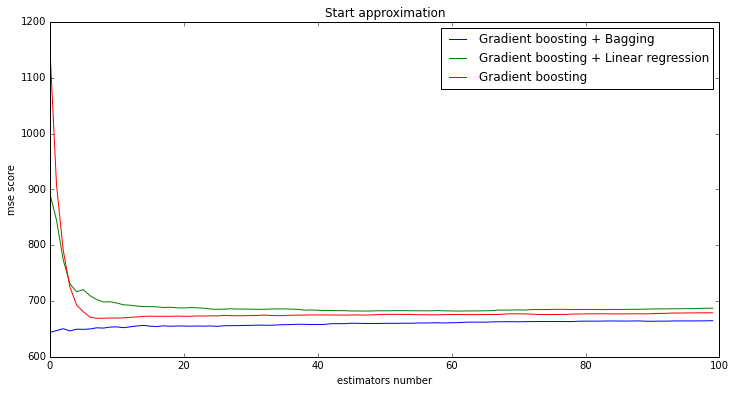

In [155]:
size = range(0, 100)
plt.figure(figsize=(12, 6))
plt.plot(size, bag_test_scores, label='Gradient boosting + Bagging')
plt.plot(size, lr_test_scores, label='Gradient boosting + Linear regression')
plt.plot(size, bst_test_scores, label='Gradient boosting')
plt.ylim(600, 1200)
plt.xlabel('estimators number')
plt.ylabel('mse score')
plt.title('Start approximation')
plt.legend(loc='best')
plt.show()

Из графика видно, что использование композиции Bagging в качестве начального приближения повысило точность градиентного бустинга, что закономерно, так как градиентный бустинг на каждом шаге пытается улучшить начальное приближение. Хорошее начально приближение облегчает эту задачу. Начальное приближение в случае линейной регрессии имело не очень высокое качество, и видимо поэтому даже ухудшило исходный бустинг.

## Смесь алгоритмов

Обучите линейную регрессию (LR), Random Forest (RF) и градиентный бустинг (GBDT). Подберите оптимальные $\alpha$ для алгоритмов $\alpha \cdot RF + (1 - \alpha) \cdot GBDT$ и $\alpha \cdot LR + (1 - \alpha) \cdot GBDT$. Сравните качество новых моделей между собой и моделями из предыдущего пункта.

In [171]:
LR = LinearRegression()
LR.fit(train_data, labels)
LR_train_prediction = LR.predict(train_data)
LR_test_prediction = LR.predict(test_data)
print 'MSE: ', mean_squared_error(LR_test_prediction, test_labels)

MSE:  980.354906778


In [165]:
RF = RandomForestRegressor(n_estimators=250, min_samples_split=2, min_samples_leaf=3)
RF.fit(train_data, labels)
RF_train_prediction = RF.predict(train_data)
RF_test_prediction = RF.predict(test_data)
print 'MSE: ', mean_squared_error(RF_test_prediction, test_labels)

MSE:  610.421347573


In [162]:
GBDT = xgb.train(param, dtrain, 250, evallist, verbose_eval=False, early_stopping_rounds=10)
GBDT_train_prediction = GBDT.predict(dtrain)
GBDT_test_prediction = GBDT.predict(dtest)
print 'MSE: ', mean_squared_error(GBDT_test_prediction, test_labels)

MSE:  684.084169976


In [207]:
def find_optimal_alpha(pred_1, pred_2, real):
    pred_1, pred_2 = np.array(pred_1), np.array(pred_2)
    mse = []
    for alpha in np.linspace(0., 1.0, 100):
        pred = pred_1*alpha + pred_2*(1-alpha)
        score = mean_squared_error(pred, real)
        mse.append(score)
    return np.argmin(mse)*(0.01), mse

rf_alpha, rf_errors = find_optimal_alpha(RF_test_prediction, GBDT_test_prediction, test_labels)
lr_alpha, lr_errors = find_optimal_alpha(LR_test_prediction, GBDT_test_prediction, test_labels)

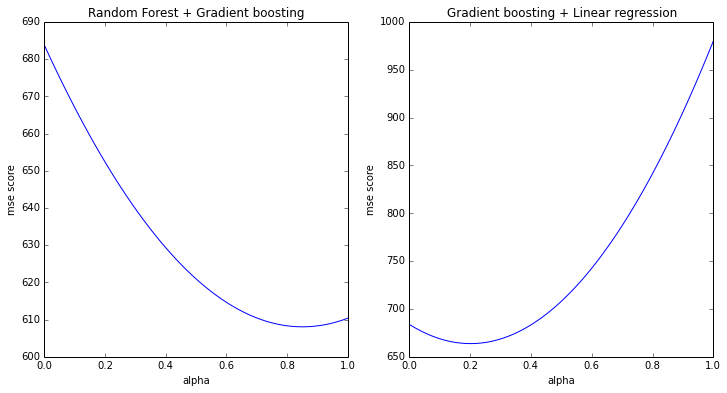

In [205]:
size = np.linspace(0, 1.0, 100)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(size, rf_errors)
plt.xlabel('alpha')
plt.ylabel('mse score')
plt.title('Random Forest + Gradient boosting')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(size, lr_errors)
plt.xlabel('alpha')
plt.ylabel('mse score')
plt.title('Gradient boosting + Linear regression')
plt.show()

In [208]:
print 'Random forest + Gradient boost alpha:', rf_alpha
print 'Random forest + Linear regression alpha:', lr_alpha

Random forest + Gradient boost alpha: 0.84
Random forest + Linear regression alpha: 0.2


In [212]:
rf_predict = rf_alpha * RF_test_prediction + (1.-rf_alpha) * GBDT_test_prediction
lr_predict = lr_alpha * LR_test_prediction + (1.-lr_alpha) * GBDT_test_prediction
print 'Random forest + Gradient boost MSE: {:.2f}'.format(mean_squared_error(rf_predict, test_labels))
print 'Random forest + Linear regression MSE: {:.2f}'.format(mean_squared_error(lr_predict, test_labels))

Random forest + Gradient boost MSE: 608.07
Random forest + Linear regression MSE: 663.81


Видим, что смесь Random forest + Gradient boost получилась отличная. Эта модель имеет наименьшую ошибку из всех ранее построенных. В случае линейной регрессии лучше было бы совсем не смешивать. Эта модель сама по себе имеет значительно более низкое качество, чем остальные модели. Поэтому в смесь она добавит больше ошибок, чем полезной информации.